In [1]:

import ctypes
ctypes.CDLL("libiomp5md.dll", mode=ctypes.RTLD_GLOBAL)
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import copy
import time

import pytorch_utils
import dataset_utils

print("\nInitializing PyTorch...")
utils = pytorch_utils.Utils(dataset_utils.MyDataset, 0.8, 0.15, 0.05)
utils.dataset.select_target("count")

input_size  = utils.dataset.X.shape[1] * utils.dataset.X.shape[2]
output_size = utils.dataset.Y.shape[1]

print("Success!", input_size, output_size)


Initializing PyTorch...
Cuda available:  True
Using Cuda:      True
Loading npz dataset file...
(46799, 64, 64, 2)
NVIDIA GeForce RTX 3060
Success! 4096 1


In [2]:
from functools import reduce
from operator import __add__

class Conv2dSamePadding(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(Conv2dSamePadding, self).__init__(*args, **kwargs)
        self.zero_pad_2d = nn.ZeroPad2d(reduce(__add__,
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_size[::-1]]))

    def forward(self, input):
        return  self._conv_forward(self.zero_pad_2d(input), self.weight, self.bias)

class CNN(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, stride, activation):
        super().__init__()

        self.conv = Conv2dSamePadding(
            in_channels=channels_in, 
            out_channels=channels_out, 
            kernel_size=kernel_size, 
            stride = stride,
            bias=False
        )

        self.bn = nn.BatchNorm2d(channels_out)

        self.activation = activation

    def forward(self, x):
        x = self.bn(self.conv(x))
        if self.activation:
            x = F.leaky_relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, stride):
        super().__init__()
        
        self.cnn1 = CNN(channels_in , channels_out, kernel_size, stride, activation=True)
        self.cnn2 = CNN(channels_out, channels_out, kernel_size, 1     , activation=False)

        self.residual_scaling = nn.Parameter(torch.tensor(0.1), requires_grad=True)

        self.stride = stride
        self.downsample = None
        if self.stride > 1:
            self.downsample = CNN(channels_in , channels_out, kernel_size = 1, stride=stride, activation=False)

    def forward(self, x):
        residual = self.downsample(x) if self.stride > 1 else x
        
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = x * self.residual_scaling + residual
        x = F.leaky_relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, params):
        super(ResNet, self).__init__()

        self.layers = nn.ModuleList()

        block_count = 1
        stages = 3
        filters_start = 64
        kernel_size = 3

        original_channels = 1

        self.layers.append(CNN(original_channels, filters_start, kernel_size, stride = 1, activation = True))
        prev_channels_out = filters_start
        for stage in range(stages):
            for block in range(block_count):
                channels_out = filters_start * (1 << stage)
                stride = 2 if stage > 0 and block == 0 else 1
                self.layers.append(ResidualBlock(prev_channels_out, channels_out, kernel_size, stride))
                prev_channels_out = channels_out

        self.layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        #print("prev_channels_out", prev_channels_out)
        self.linear = nn.Linear(prev_channels_out, 1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        x = x.to(torch.float32)
        for layer in self.layers:
            x = layer(x)

        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

    def get_input_weights(self):
        return torch.tensor(0)

gamma per epoch: 1.5848931924611136
residual: 7.105427357601002e-14
Test; 	Test loss: 6.4190923 	 time: 14s           

Initial: Train loss: 6.4190923

Step:1 	Train loss: 2.5208137 	LR: 5.00e-04	 time: 43s
Step:2 	Train loss: 2.5135856 	LR: 7.92e-04	 time: 43s
Step:3 	Train loss: 2.5010418 	LR: 1.26e-03	 time: 43s
Step:4 	Train loss: 2.5472213 	LR: 1.99e-03	 time: 43s
Step:5 	Train loss: 2.5767993 	LR: 3.15e-03	 time: 43s
Step:6 	Train loss: 2.4574807 	LR: 5.00e-03	 time: 44s
Step:7 	Train loss: 2.4328806 	LR: 7.92e-03	 time: 43s
Step:8 	Train loss: 2.3485483 	LR: 1.26e-02	 time: 44s
Step:9 	Train loss: 2.4095335 	LR: 1.99e-02	 time: 43s
Step:10 	Train loss: 2.4830944 	LR: 3.15e-02	 time: 44s

Time to train: 446.212s


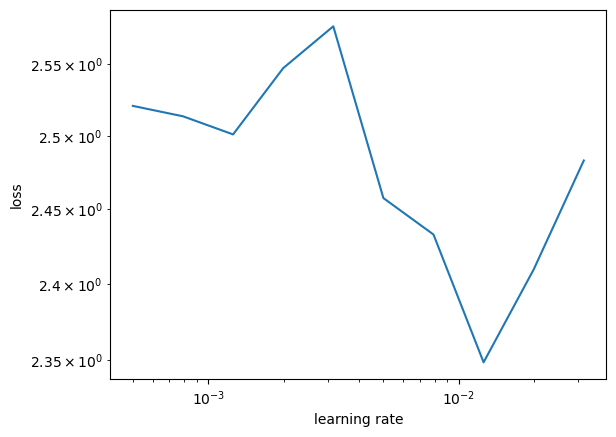

Best learning rate: 0.012559432157547906
best_lr: 0.012559432157547906


In [3]:
params = {'batch_size': 16, 'loss': F.smooth_l1_loss, 'weight_decay': 0, 'epochs': 10, 'lr': 1e-5, 'batch_growth': False, 'l1_reg': 0}

min_lr = 5e-4
max_lr = 5e-2

model, train_losses, learning_rates, best_lr_ResNet = utils.Learning_Rate_Range_Test(ResNet, min_lr, max_lr, params)
print("best_lr:", best_lr_ResNet)

In [4]:
params = {'batch_size': 16, 'loss': F.smooth_l1_loss, 'weight_decay': 1e-5, 'epochs': 50, 'lr': best_lr_ResNet, 'batch_growth': False, 'l1_reg': 0}
max_batch_size = 256
best_model, best_val_loss, final_model, train_losses, val_losses = utils.train_model(ResNet, params, max_batch_size, print_mode=True)

Test; 	Test loss: 6.4932294 	 time: 3s            

Initial: Test loss: 6.4932294

Test; 	Test loss: 2.6414050 	 time: 3s            
Epoch:1 	Train loss: 2.7124999 	Val loss: 2.6414050 	batch size: 16	 LR: 1.25e-02	 time: 45s
Test; 	Test loss: 2.1797561 	 time: 3s            
Epoch:2 	Train loss: 2.1075008 	Val loss: 2.1797561 	batch size: 16	 LR: 1.25e-02	 time: 45s
Test; 	Test loss: 2.1202708 	 time: 3s            
Epoch:3 	Train loss: 1.9687498 	Val loss: 2.1202708 	batch size: 16	 LR: 1.24e-02	 time: 45s
Test; 	Test loss: 1.8253560 	 time: 3s            
Epoch:4 	Train loss: 1.8967010 	Val loss: 1.8253560 	batch size: 16	 LR: 1.24e-02	 time: 45s
Test; 	Test loss: 1.9258612 	 time: 3s            
Epoch:5 	Train loss: 1.8544336 	Val loss: 1.9258612 	batch size: 16	 LR: 1.23e-02	 time: 46s
Test; 	Test loss: 1.8132954 	 time: 3s            
Epoch:6 	Train loss: 1.8133446 	Val loss: 1.8132954 	batch size: 16	 LR: 1.21e-02	 time: 45s
Test; 	Test loss: 1.8590010 	 time: 3s            
Ep

In [8]:
torch.save(best_model.state_dict(), "ResNet1.dict")

In [6]:
params = {'batch_size': 16, 'loss': F.smooth_l1_loss, 'weight_decay': 1e-3, 'epochs': 50, 'lr': best_lr_ResNet, 'batch_growth': False, 'l1_reg': 0}
max_batch_size = 256
best_model, best_val_loss, final_model, train_losses, val_losses = utils.train_model(ResNet, params, max_batch_size, print_mode=True)

Test; 	Test loss: 6.4936434 	 time: 3s            

Initial: Test loss: 6.4936434

Test; 	Test loss: 2.5272566 	 time: 4s            
Epoch:1 	Train loss: 2.8823194 	Val loss: 2.5272566 	batch size: 16	 LR: 1.99e-03	 time: 60s
Test; 	Test loss: 2.4921245 	 time: 3s            
Epoch:2 	Train loss: 2.0940895 	Val loss: 2.4921245 	batch size: 16	 LR: 1.98e-03	 time: 73s
Test; 	Test loss: 2.1517120 	 time: 3s            
Epoch:3 	Train loss: 1.9750865 	Val loss: 2.1517120 	batch size: 16	 LR: 1.97e-03	 time: 67s
Test; 	Test loss: 2.2061101 	 time: 3s            
Epoch:4 	Train loss: 1.9118599 	Val loss: 2.2061101 	batch size: 16	 LR: 1.96e-03	 time: 65s
Test; 	Test loss: 2.0522352 	 time: 3s            
Epoch:5 	Train loss: 1.8905068 	Val loss: 2.0522352 	batch size: 16	 LR: 1.94e-03	 time: 53s
Test; 	Test loss: 2.0376749 	 time: 3s            
Epoch:6 	Train loss: 1.8419415 	Val loss: 2.0376749 	batch size: 16	 LR: 1.92e-03	 time: 50s
Test; 	Test loss: 2.2504426 	 time: 3s            
Ep

In [9]:
params = {'batch_size': 32, 'loss': 'SmoothL1', 'weight_decay': 1e-5, 'hidden_size': 100, 'dropout_rate': 0, 'epochs': 10, 'lr': 1e-5, 'batch_growth': False, 'l1_reg': 0}
model = ResNet(params)
model.load_state_dict(torch.load("ResNet1.dict", weights_only=True))
model = model.cuda()
utils.dataset.evaluate_model(model, 32)

Train metrics:
	MSE: tensor(5.4354, device='cuda:0')

	RMSE: tensor(2.3314, device='cuda:0')

	MAE: tensor(1.6670, device='cuda:0')

Validation metrics:
	MSE: tensor(6.7290, device='cuda:0')

	RMSE: tensor(2.5940, device='cuda:0')

	MAE: tensor(1.9078, device='cuda:0')

Test metrics:
	MSE: tensor(6.0708, device='cuda:0')

	RMSE: tensor(2.4639, device='cuda:0')

	MAE: tensor(1.8133, device='cuda:0')


tensor(0., device='cuda:0', dtype=torch.float16) tensor(1., device='cuda:0', dtype=torch.float16)
torch.Size([64, 64])


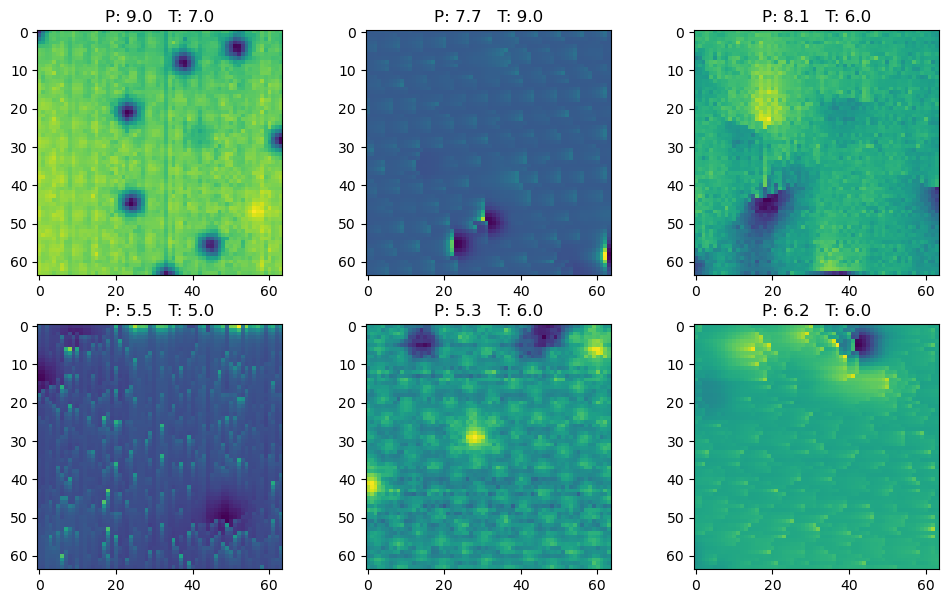

In [24]:
#This function gives the ldos from a model
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("ResNet1.dict", weights_only=True))
model = model.cuda()
#model.eval()

preds = model(utils.dataset.X_test[:6])

print(torch.min(utils.dataset.X_test[0]), torch.max(utils.dataset.X_test[0]))
print(utils.dataset.X_test[0].shape)

plt.figure(figsize=(12, 7))  
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(utils.dataset.X_test[i].cpu().T)
    plt.title("P: {:.1f}   T: {}".format(float(preds[i].cpu()), float(utils.dataset.Y_test[i].cpu())))
plt.show()

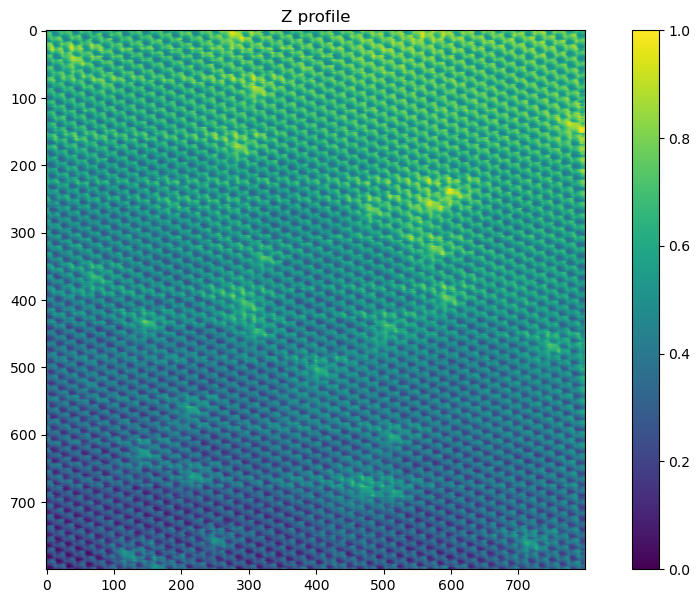

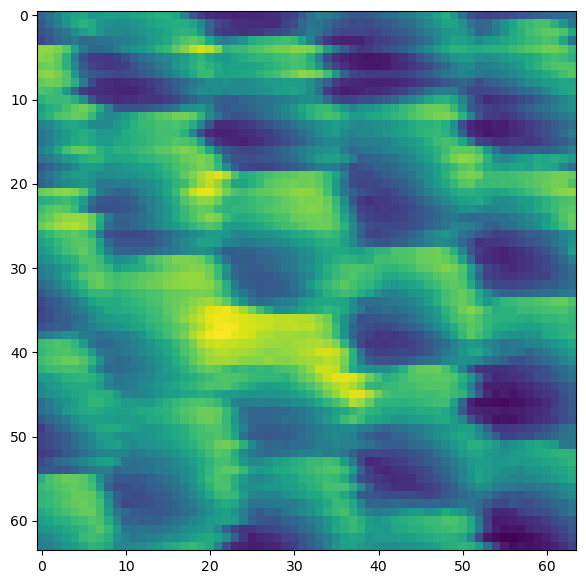

In [15]:
import struct

def load_sample(path):
    with open(path, 'rb') as f:
        data = f.read()
        f.close()
    
    topo = []
    for i in range(int(len((data))/4)):
        topo_numvalue = struct.unpack('<i', data[4*i:4*i+4])[0]
        topo.append(topo_numvalue)
    
    topo = np.array(topo)
    res = int(np.sqrt(topo.shape[0]))
    topo = topo.reshape(res, res)
    #topo_min = np.min(topo, axis = 1)[:, None]
    #topo_max = np.max(topo, axis = 1)[:, None]
    #topo = (topo - topo_min) / (topo_max - topo_min)
    topo = (topo - np.min(topo)) / (np.max(topo) - np.min(topo))
    return topo

folder = "20230818_Lance_WSe2-CVD[10K]/"
#file = "20230818_Lance_WSe2-CVD_163TopoBwd.int"
file = "20230818_Lance_WSe2-CVD_164TopoBwd.int"

path = folder + file
topo = load_sample(path)

plt.figure(figsize=(12, 7)) 
plt.imshow(topo)

plt.title("Z profile")
plt.colorbar()
plt.show()

res = 64

off_x = 300
off_y = 300

test_sample = topo[off_x:off_x+res, off_y:off_y+res]

plt.figure(figsize=(12, 7)) 
plt.imshow(test_sample)
#plt.colorbar()
plt.show()

In [22]:
model.eval()

test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype = torch.float16).cuda()
test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
print(torch.max(test_sample_t), torch.min(test_sample_t))

print(model(test_sample_t))

tensor(1., device='cuda:0', dtype=torch.float16) tensor(0., device='cuda:0', dtype=torch.float16)
tensor([[27.8857]], device='cuda:0', grad_fn=<AddmmBackward0>)
